# Draw phylogenies of Ireland and global M. bovis samples

<div class="alert alert-block alert-info"><b>R Script to draw trees</b> </div>

In [10]:
setwd('/home/farrell/gitprojects/snipgenie/notebooks')
source('drawtrees.R')
library(phytools)

In [3]:
gltree <- read.tree('/storage/btbgenie/global_results/tree.newick')
gltree <- midpoint.root(gltree)

In [4]:
gmeta <- read.table('/storage/btbgenie/global_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
gmeta[] <- lapply(gmeta, as.character)
print (length(rownames(gmeta)))

[1] 6670


In [5]:
cladecolors <- c(
  '1'= "#4AA60E",
  '2'= "#BDDC28",
  '3'= "#F34DA5",
  '4'= "#0969A2",
  '5'= "#FF8C00",
  '6' = "#FF3D00",
  '7' = "#5b9b71",  
  '8' = "#79ecdd",
  '9' = "#5ACDF1",
  '10' = "#A62800",
  '11' = "#bbbbbb",
  '12' = "#C3E0E4",
  '13' = "#CF7143",
  '14' = "#CFA127",
  '15' = "#C029C5",
  '16'="#989c0e",
  '17'="#FFC073",
  '18'="#C3E0E4"
)
continent_colors <- c(
  "Ireland" = "#1DB954",        # Green
  "United Kingdom" = "#0072B2", # Blue
  "Europe" = "#FF7F00",         # Orange
  "North America" = "#A6CEE3",
  "South America" = "#FB9A99",
  "Asia" = "#B15928",
  "Africa" = "#CAB2D6",
  "Oceania" = "#FFFF99",
  "Antarctica" = "#CFCFCF"
)

In [6]:
countries_to_keep <- c("GB", "Ireland")

gmeta$Region <- NA
gmeta$Region[gmeta$Region %in% countries_to_keep] <- 
  gmeta$Country[gmeta$Region %in% countries_to_keep]
gmeta[1:5,]

,Clonal_Complex,Country,Country_Patient_Birth,Gnumber,Host,Map,SIB_Number,Sample.included.in.Loiseau.et.al..2020,Species,SB1,Level.1,short_name,main_lineage,sub_lineage,spoligotype,Continent,Region
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ERS2573045,La1.6,Nigeria,Nigeria,G02538,Human,1,SB0944,1,M.bovis,,NA,,,,,Africa,NA
ERR1203064,La1.6,Ghana,,G08506,Human,1,SB0944,1,M.bovis,,NA,,,,,Africa,NA
ERR502499,La1.6,Ghana,,G08621,Human,1,SB1025,1,M.bovis,,NA,,,,,Africa,NA
ERR502526,La1.6,Ghana,,G08645,Human,1,New pattern,1,M.bovis,,NA,,,,,Africa,NA
ERR502529,La1.6,Ghana,,G08648,Human,1,SB0944,1,M.bovis,,NA,,,,,Africa,NA


## global

[1] 4.547172


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] 54.64717


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


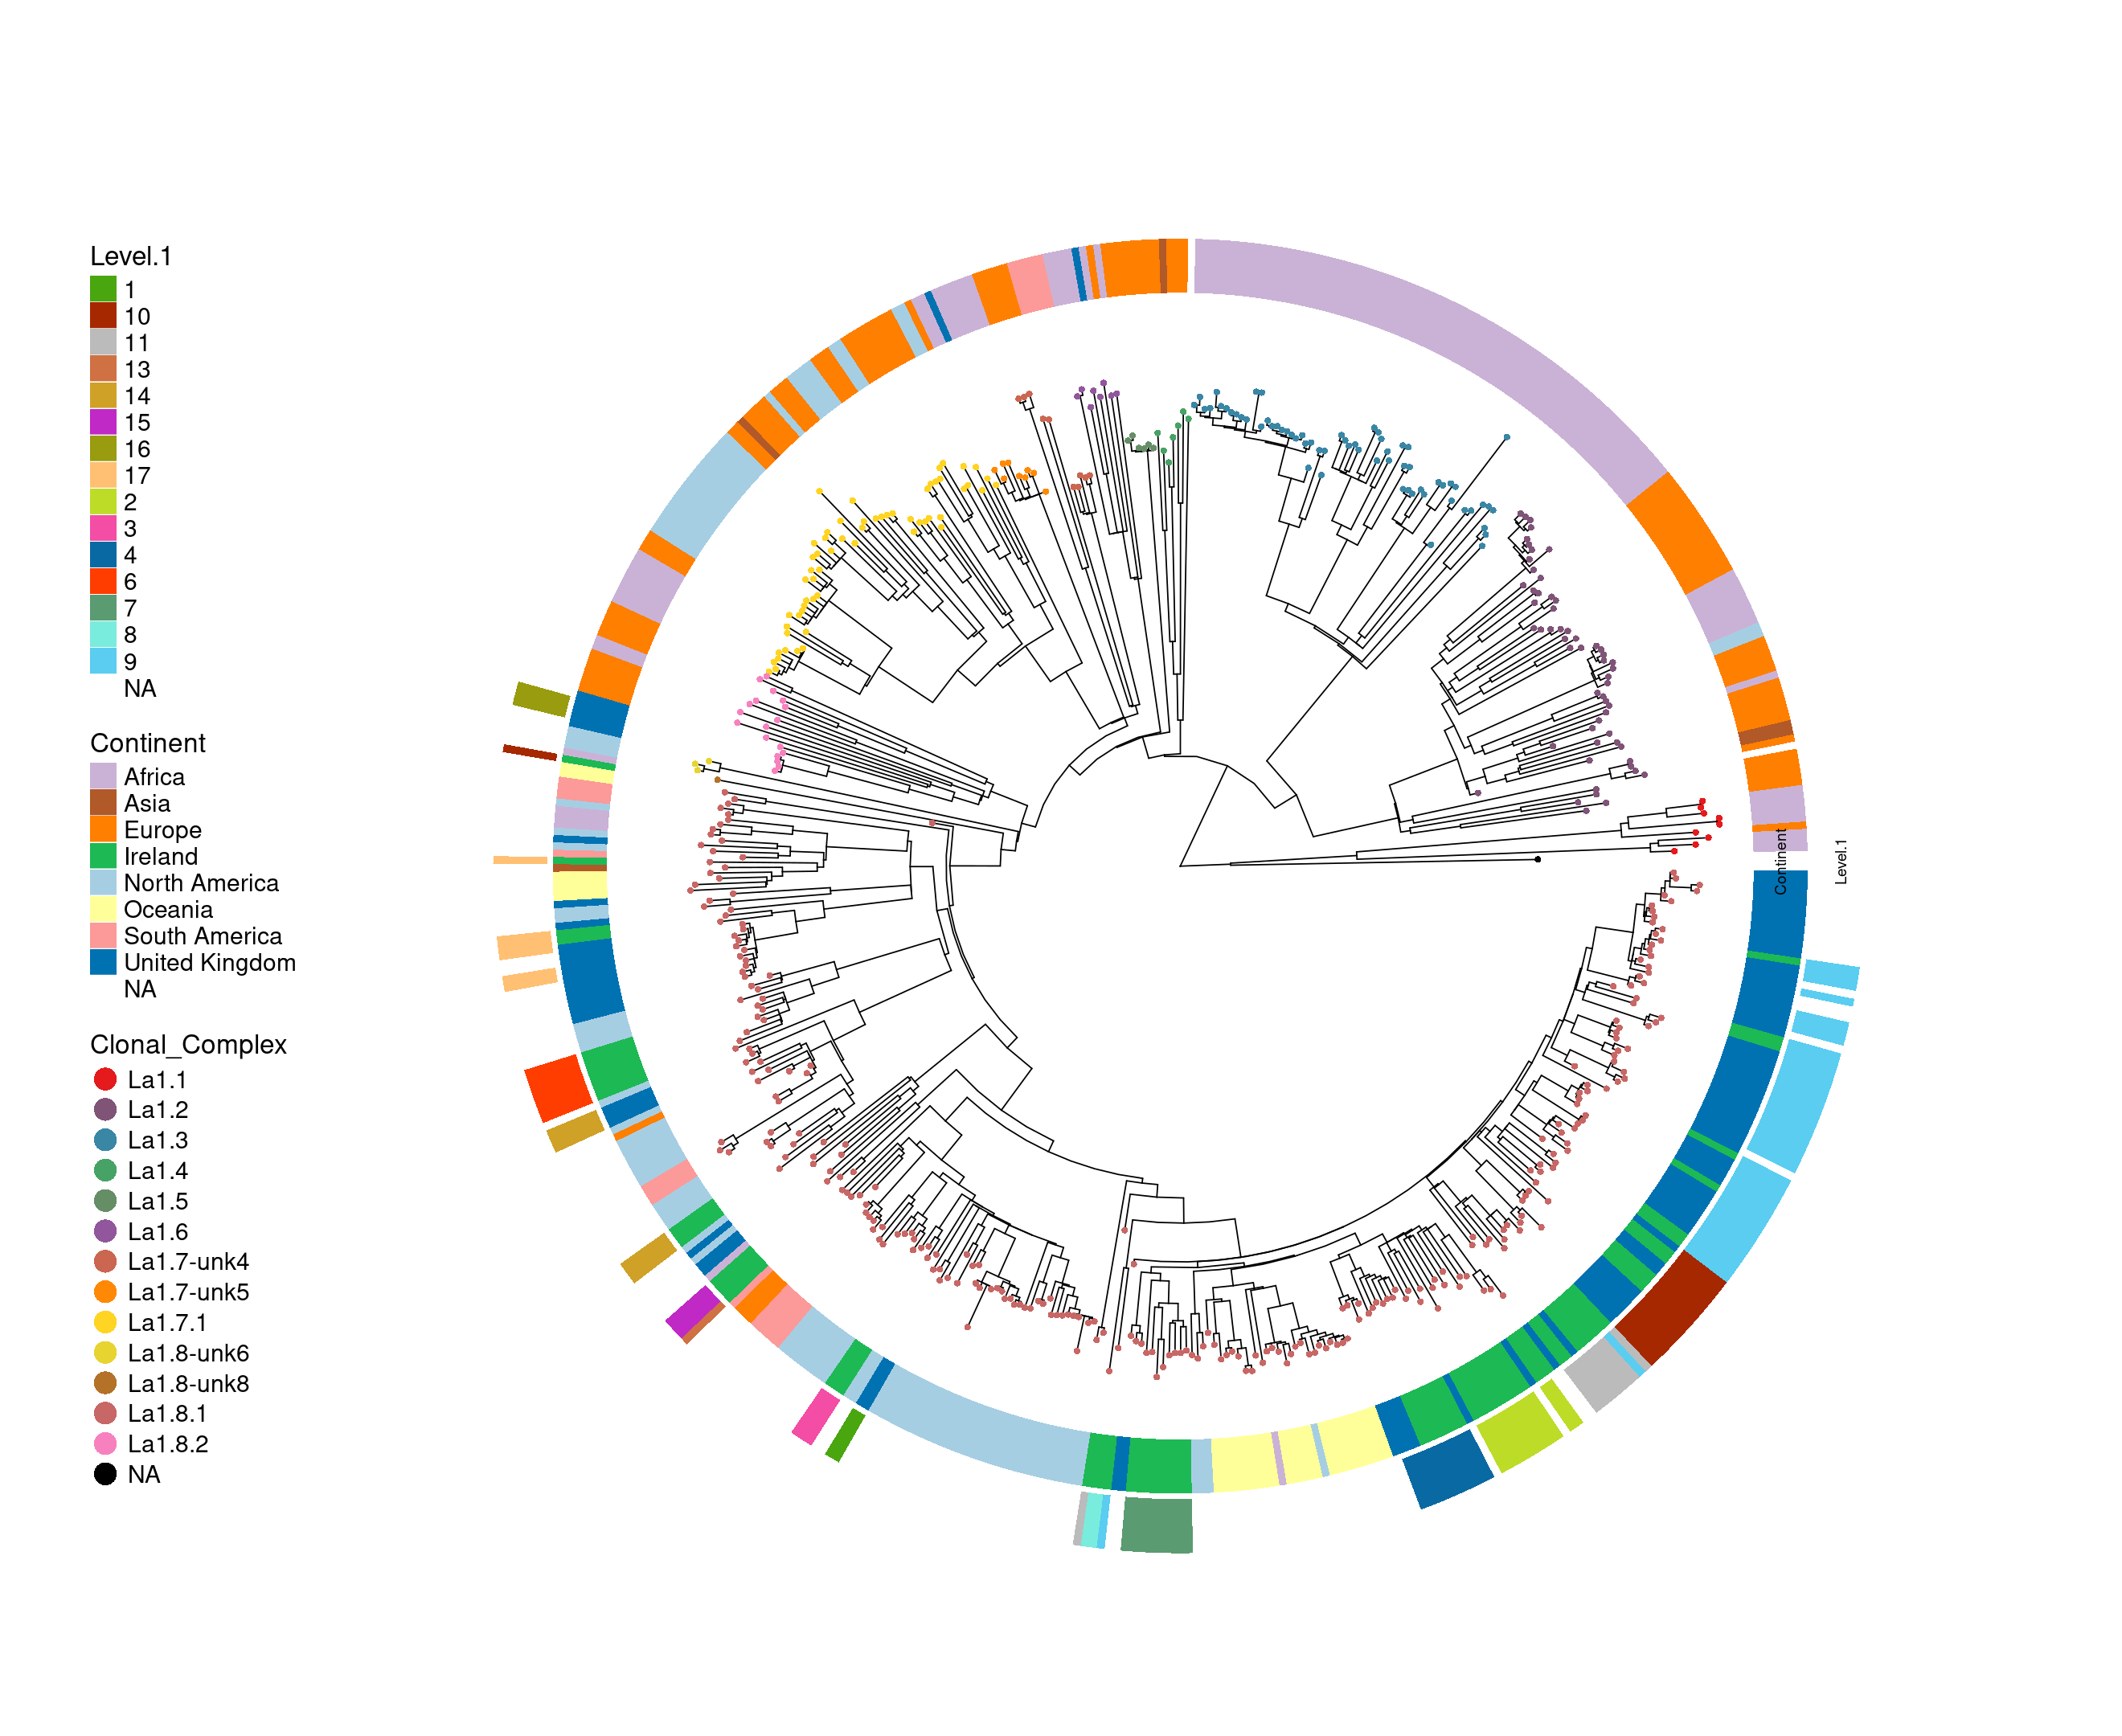

In [59]:
source('drawtrees.R')
options(repr.plot.width=22, repr.plot.height=18)
ggplottree(gltree, gmeta, layout='c', cols=c('Clonal_Complex','Continent','Level.1'), cmaps=c('Set1','Set3','Accent'),
           colors=list(NULL,continent_colors,cladecolors),
          offset=50, tipsize=2.3,  tiplabelsize=1.7, align=TRUE) # tiplabel=TRUE, tiplabelcol='Country'

In [ ]:
uniq <- row.names(distinct(gmeta,snp200,.keep_all = TRUE))
stree <- keep.tip(gtree, uniq)
#tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
#stree <- drop.tip(stree, tips)
#stree <- root(stree,'ERR1082113')
ggplottree(stree, gmeta, layout='rect', cols=c('Clonal_Complex'), cmaps=c('Paired','Set1'), tiplabel='snp200', tipsize=5, offset=100)

In [ ]:
ptree <- prune_tree(gltree, 200)
tips<-row.names(gmeta[gmeta$Clonal_Complex %in% c('La3','La2','L6'),])
ptree<-drop.tip(ptree,tips)

p<-ggplottree(ptree, gmeta, layout='cladogram', cols=c('Continent','Clonal_Complex'), cmaps=c('Set1','Set3'), 
           tipsize=3, tiplabels=TRUE, tiplabelcol='Country', offset=1,
            legends=c(TRUE,TRUE),legend.fontsize=16,         
            size=.3)

#plotcladelabels(ptree, gmeta, 'Clonal_Complex',p)
p

"daylight" method was used as default layout for unrooted tree.

Average angle change [1] 0.0293045471247825

"daylight" method was used as default layout for unrooted tree.

Average angle change [1] 0.0293045471247825



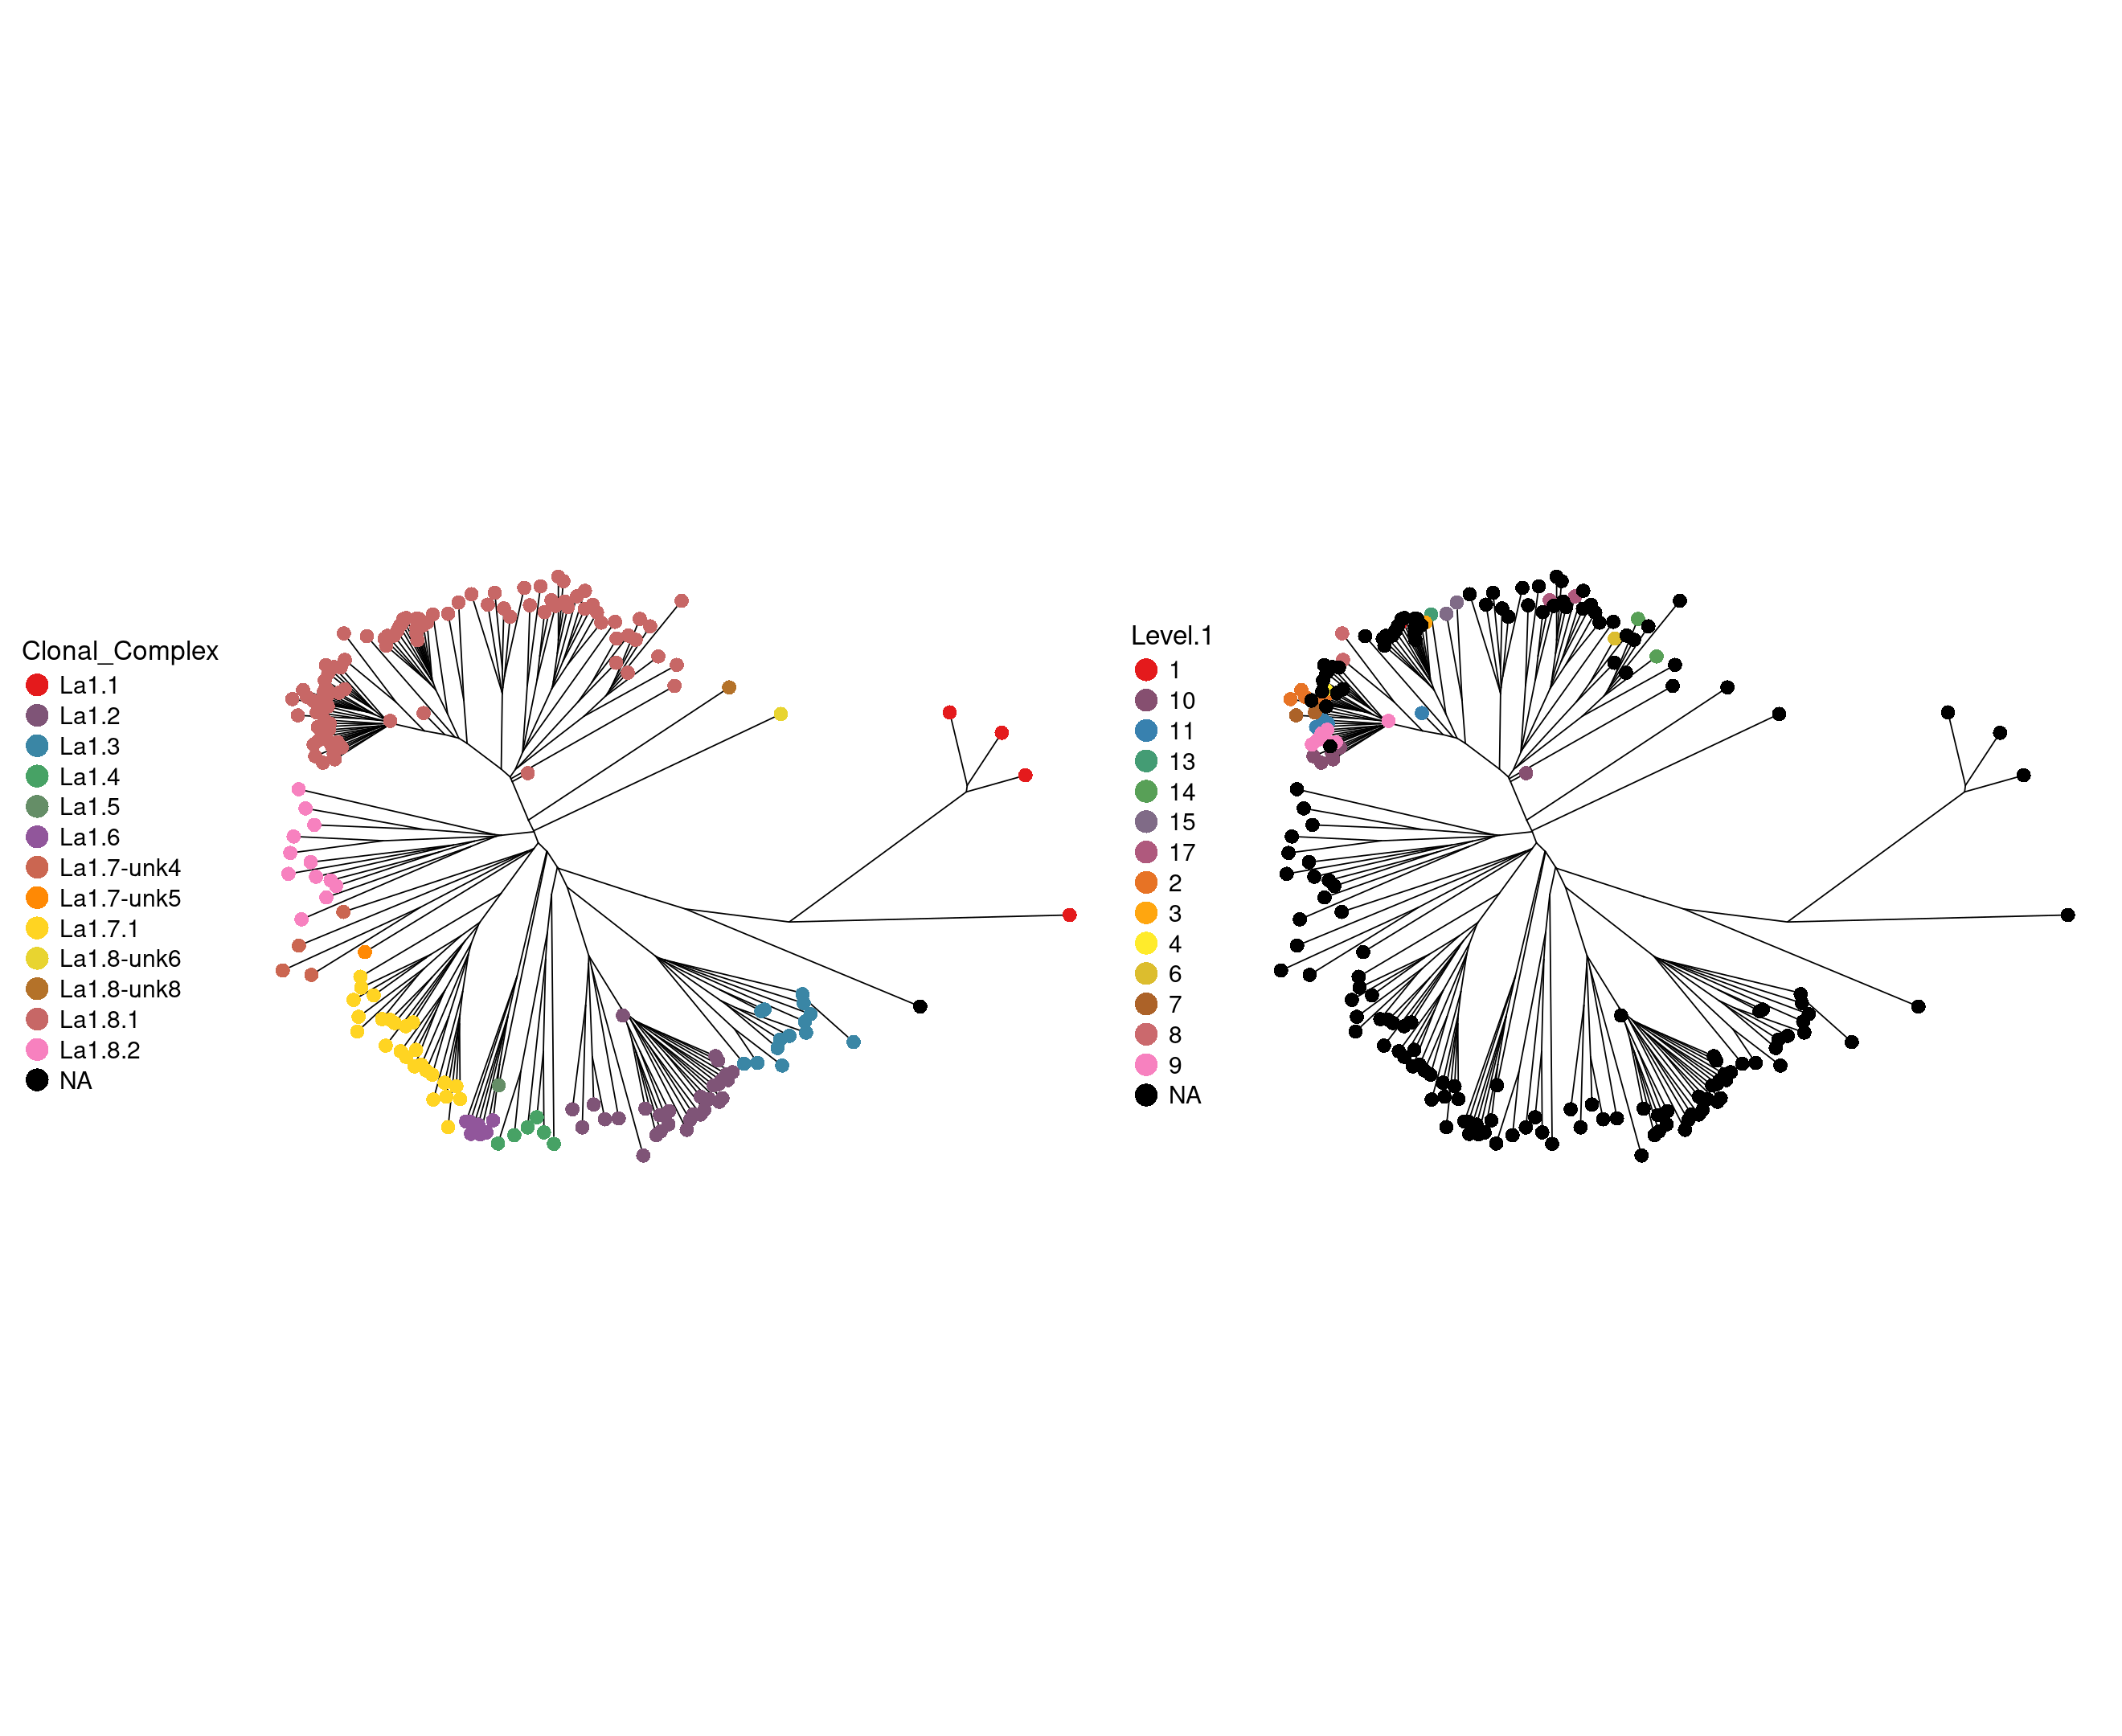

In [64]:
p1<-ggplottree(ptree, gmeta, layout='unrooted', cols=c('Clonal_Complex'), cmaps=c('Set1','Set1'),
          tipsize=5)
p2<-ggplottree(ptree, gmeta, layout='unrooted', cols=c('Level.1'), cmaps=c('Set1','Set1'),
          tipsize=5)
p1+p2

In [ ]:
#randtips<-sample(combtree$tip.label,70)
#randtree <- keep.tip(combtree, randtips)
tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree<-drop.tip(combtree,tips)
ggplottree(stree, cmeta, layout='rect', cols=c('Clonal_Complex'), cmaps=c('Set2','Paired'))

In [ ]:
options(repr.plot.width=22, repr.plot.height=12)
h1<-c('snp500','Clonal_Complex')
h2<-c(h1,c('RD149','RD3','RD5','RD5oryx.','RDAf2','RDWicklow'))
cm1<-rep('Greys',length(h2))
cm<-c(c('Set1','Paired'),cm1)
ggplottree(stree, cmeta, layout='rect', cols=h2, cmaps=cm, tipsize=5, offset=90)

## for strain selection

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


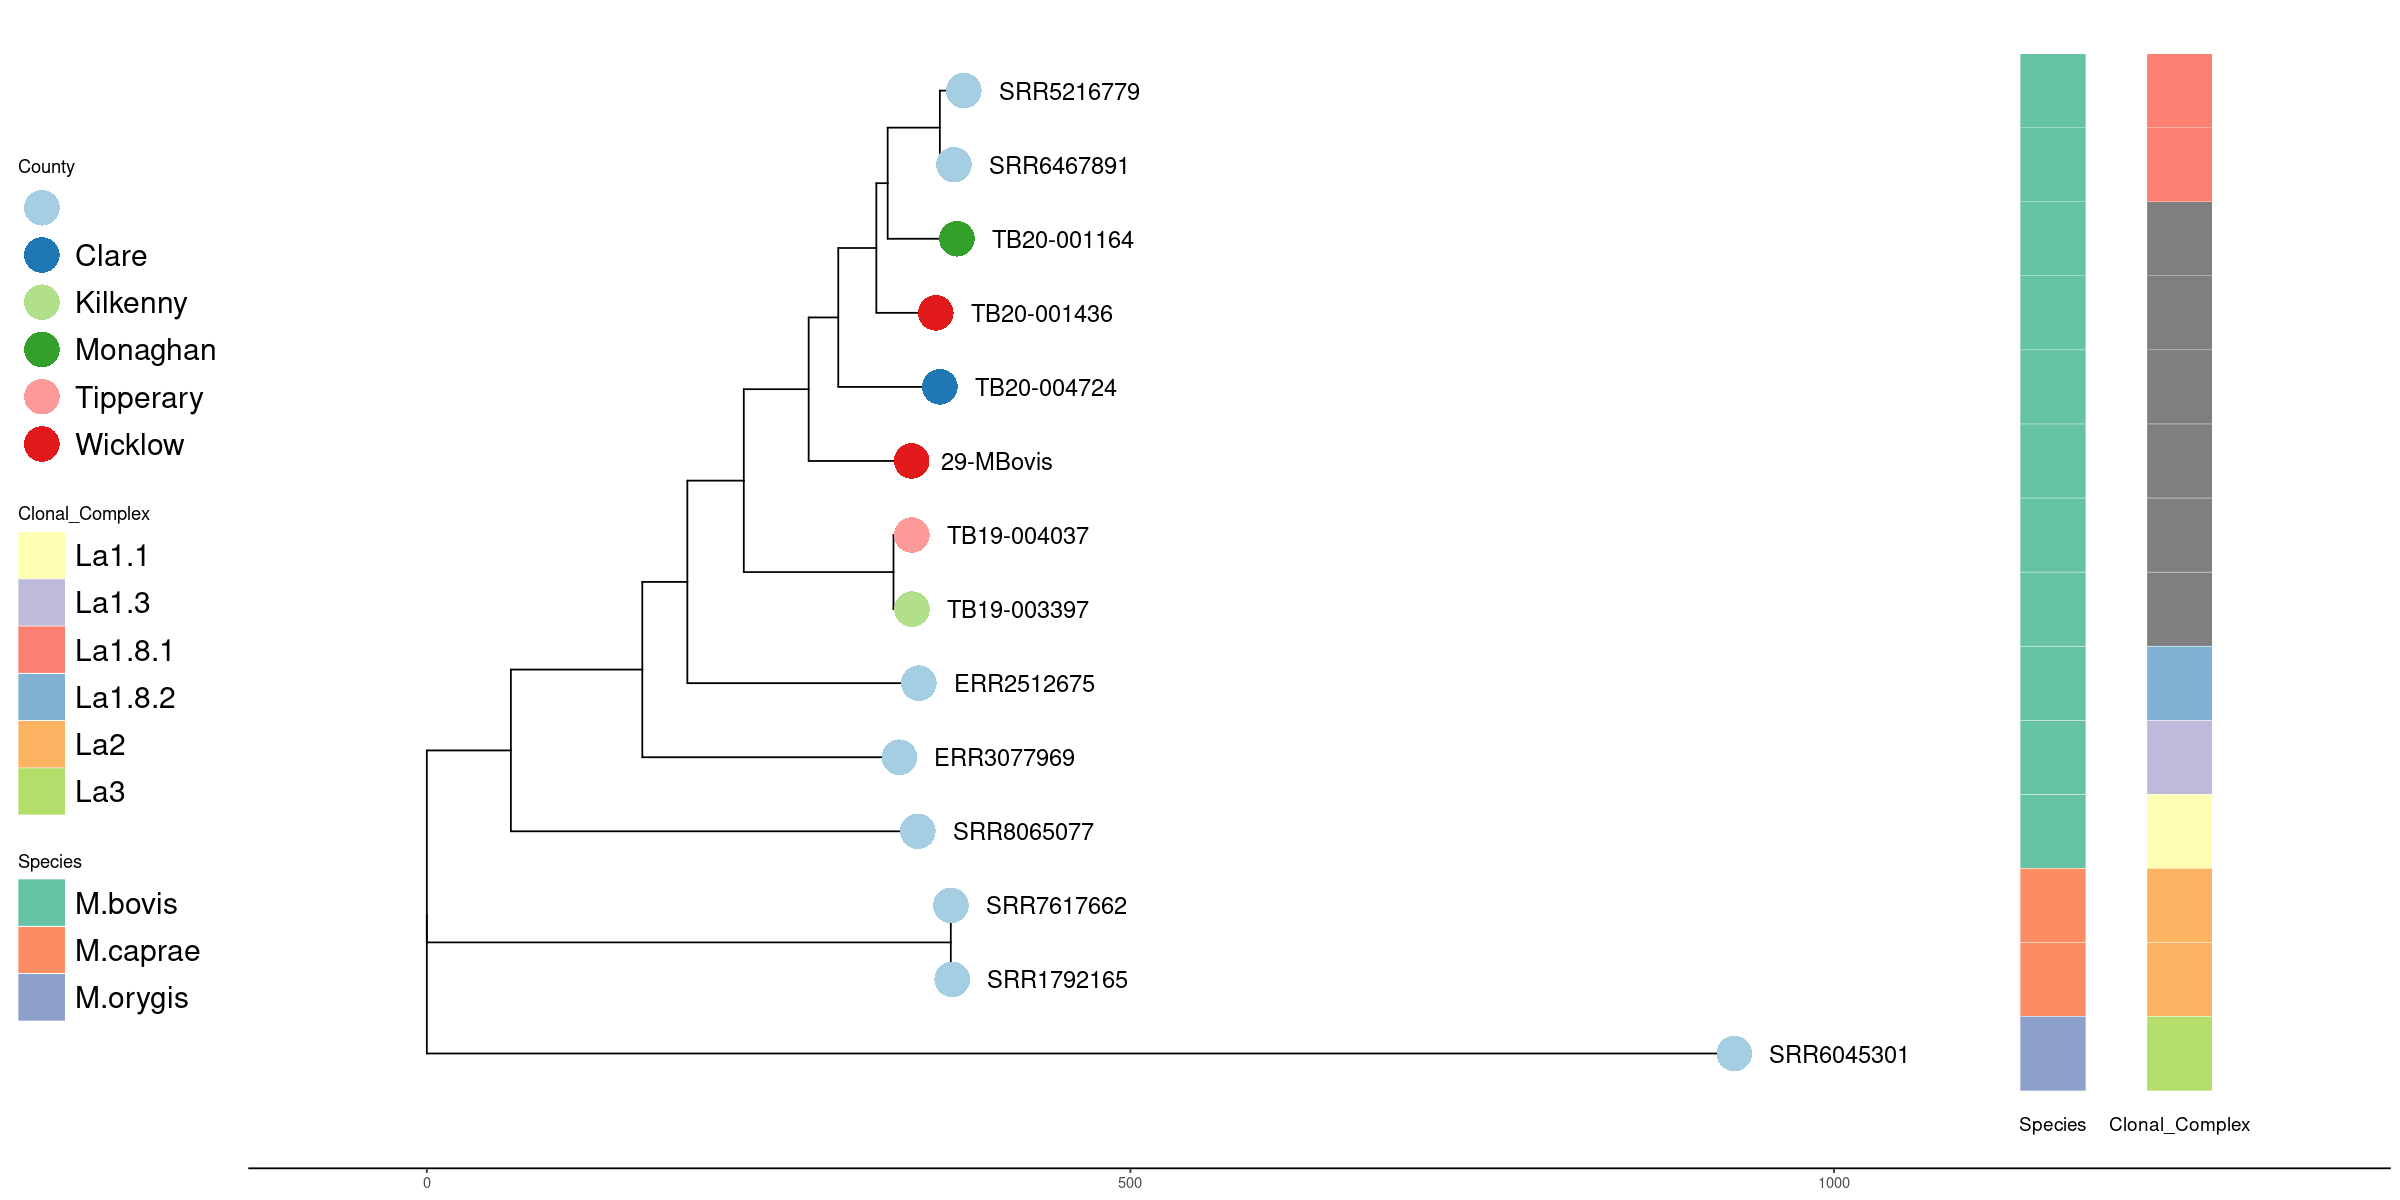

In [146]:
options(repr.plot.width=20, repr.plot.height=10)
selected <- c('TB19-004037','TB19-003397','TB20-001164','TB20-004724','TB20-001436','29-MBovis',
              'SRR1792165','SRR7617662','SRR6045301',#outgroups
              'SRR5216779','SRR6467891','ERR2512675',#UK
              'SRR8065077','ERR3077969')#other

#tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree<-keep.tip(combtree,selected)
stree <- root(stree,'SRR6045301')
ggplottree(stree, cmeta, layout='rect', cols=c('County','Species','Clonal_Complex'), cmaps=c('Paired','Set2','Set3'), tipsize=10, offset=90, tiplabel='SeqID')